# Two-Level: Collision of Two 2π Pulses

Time taken to solve this problem on a 2013 MacBook Pro:

In [1]:
import numpy as np

sech_fwhm_conv = 1./2.6339157938
t_width_1 = 2.0*sech_fwhm_conv # [τ]

print('t_width', t_width_1)

n = 2.0 # For a pulse area of nπ    
ampl_1 = n/t_width_1/(2*np.pi) # Pulse amplitude [2π Γ]

print('ampl_1', ampl_1)

t_width 0.7593257175145156
ampl_1 0.41920071827108335


In [2]:
t_width_2 = 1.0*sech_fwhm_conv # [τ]
ampl_2 = n/t_width_2/(2*np.pi)

print('t_width_2', t_width_2)
print('ampl_2', ampl_2)

t_width_2 0.3796628587572578
ampl_2 0.8384014365421667


In [3]:
mb_solve_json = """
{
  "atom": {
    "decays": [
      {
        "channels": [[0, 1]],
        "rate": 0.0
      }
    ],
    "energies": [],
    "fields": [
      {
        "coupled_levels": [[0, 1]],
        "detuning": 0.0,
        "detuning_positive": true,
        "label": "probe",
        "rabi_freq": 1.0,
        "rabi_freq_t_args": {
          "ampl": 1.0,
          "centre": 0.0,
          "width": 0.7593257175145156
        },
        "rabi_freq_t_func": "sech"
      }
    ],
    "num_states": 2
  },
  "t_min": -5.0,
  "t_max": 25.0,
  "t_steps": 240,
  "z_min": -0.5,
  "z_max": 1.5,
  "z_steps": 200,
  "z_steps_inner": 1,
  "num_density_z_func": "square",
  "num_density_z_args": {
    "on": 0.0,
    "off": 1.0,
    "ampl": 1.0
  },
  "interaction_strengths": [
    10.0
  ],
  "velocity_classes": {},
  "method": "mesolve",
  "opts": {},
  "savefile": "qu/mb-solve-two-sech-2pi-collision"
}
"""

In [4]:
from maxwellbloch import mb_solve
mb_solve_00 = mb_solve.MBSolve().from_json_str(mb_solve_json)

In [5]:
from maxwellbloch import t_funcs

probe_field = mb_solve_00.atom.fields[0]

two_pulse_t_func = lambda t, args: (t_funcs.sech(1)(t, args) +
                                    t_funcs.sech(2)(t, args))


probe_field.rabi_freq_t_func = two_pulse_t_func

probe_field.rabi_freq_t_args = {"ampl_2": ampl_2, "centre_2": 5.0,
 "width_2": t_width_2, "ampl_1": ampl_1, "centre_1": 0.0,
 "width_1": t_width_1}

mb_solve_00.atom.build_H_Omega(); # We have to rebuild H_Omega

mb_solve_00.init_Omegas_zt();

We'll just check that the pulse area is what we want. Should be 4π

In [6]:
print('The input pulse area is {0:.4f}π'.format(np.trapz(mb_solve_00.Omegas_zt[0,0,:].real, 
                                                     mb_solve_00.tlist)/np.pi))

The input pulse area is 3.9982π


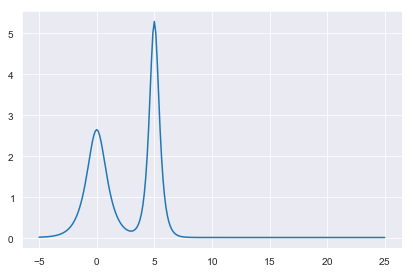

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

plt.plot(mb_solve_00.tlist, np.abs(mb_solve_00.Omegas_zt[0,0,:]))

## Solve the Problem

In [8]:
%time Omegas_zt, states_zt = mb_solve_00.mbsolve(step='ab', recalc=False, pbar_chunk_size=5)

Loaded tuple object.
CPU times: user 7.27 ms, sys: 9.05 ms, total: 16.3 ms
Wall time: 13.7 ms


## Plot Output

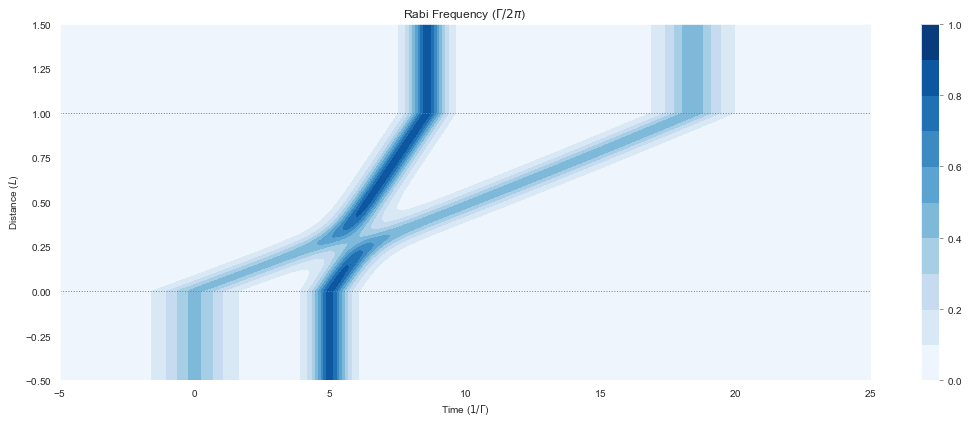

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np

sns.set_style('darkgrid')
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(111)
cmap_range = np.linspace(0.0, 1.0, 11)
cf = ax.contourf(mb_solve_00.tlist, mb_solve_00.zlist, 
                 np.abs(mb_solve_00.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Time ($1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf)
plt.savefig('images/mb-solve-two-sech-2pi-collision.png')

## Pulse area

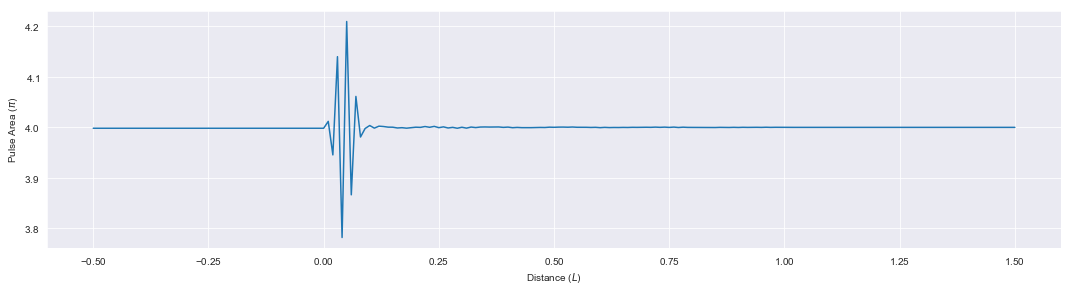

In [10]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(mb_solve_00.zlist, mb_solve_00.fields_area()[0]/np.pi, clip_on=False)
# ax.set_ylim([0.0, 4.0])
ax.set_xlabel('Distance ($L$)')
ax.set_ylabel('Pulse Area ($\pi$)');

## Movie

In [11]:
C = 0.1 # speed of light
Y_MIN = 0.0 # Y-axis min
Y_MAX = 4.0 # y-axis max
ZOOM = 2 # level of linear interpolation
FPS = 60 # frames per second
ATOMS_ALPHA = 0.2 # Atom indicator transparency

In [12]:
FNAME = "images/mb-solve-two-sech-2pi-collision"
FNAME_JSON = FNAME + '.json'
with open(FNAME_JSON, "w") as f:
    f.write(mb_solve_json)

In [13]:
!make-mp4-fixed-frame.py -f $FNAME_JSON -c $C --fps $FPS --y-min $Y_MIN --y-max $Y_MAX \
    --zoom $ZOOM --atoms-alpha $ATOMS_ALPHA #--peak-line --c-line

Namespace(atoms_alpha='0.2', c_line=False, file='images/mb-solve-two-sech-2pi-collision.json', fps='60', peak_line=False, save_path='./', speed_of_light='0.1', y_max='4.0', y_min='0.0', zoom='2')
Loaded tuple object.
Saving MP4
./images/mb-solve-two-sech-2pi-collision.mp4
Figure(1200x400)


In [14]:
FNAME_MP4 = FNAME + '.mp4'
!make-gif-ffmpeg.sh -f $FNAME_MP4 --in-fps $FPS

Converting images/mb-solve-two-sech-2pi-collision.mp4 to gif format
Input Scale: 900
Input FPS: 60
Output Scale: 900
Output FPS: 30
/Users/tommy/.miniconda3/envs/mb-0.4.0/bin/make-gif-ffmpeg.sh: line 59: Y: command not found
ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 8.0.0 (clang-800.0.42.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.2.4 --enable-shared --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --disable-lzma --enable-vda
  libavutil      55. 34.101 / 55. 34.101
  libavcodec     57. 64.101 / 57. 64.101
  libavformat    57. 56.101 / 57. 56.101
  libavdevice    57.  1.100 / 57.  1.100
  libavfilter     6. 65.100 /  6. 65.100
  libavresample   3.  1.  0 /  3.  1.  0
  libswscale      4.  2.100 /  4.  2.100
  libswresample   2.  3.100 /  2.  3.100
  libpostproc  

In [15]:
from IPython.display import Image
Image(url=FNAME_MP4 +'.gif', format='gif')